✅ All libraries imported successfully
📊 Data Loaded:
   Training samples: 400
   Test samples: 100
   Features: 12
   Target range: [40.00, 99.00]
🔧 Model Configurations:
   ✓ KNN
   ✓ DECISION_TREE
   ✓ RANDOM_FOREST
TRAINING BASE MODELS WITH 10-FOLD CROSS-VALIDATION

🔄 Training KNN...
   ✅ KNN Trained
      10-Fold CV RMSE: 18.9719 ± 24.6973
      Test RMSE: 15.5873
      Test MAE: 12.8067
      Test R²: 0.1051
      Best Params: {'n_neighbors': 9, 'weights': 'uniform'}

🔄 Training DECISION_TREE...
   ✅ DECISION_TREE Trained
      10-Fold CV RMSE: 18.7951 ± 25.1020
      Test RMSE: 16.1659
      Test MAE: 13.6919
      Test R²: 0.0375
      Best Params: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}

🔄 Training RANDOM_FOREST...
   ✅ RANDOM_FOREST Trained
      10-Fold CV RMSE: 18.6085 ± 27.3253
      Test RMSE: 13.5585
      Test MAE: 11.3906
      Test R²: 0.3229
      Best Params: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 50}


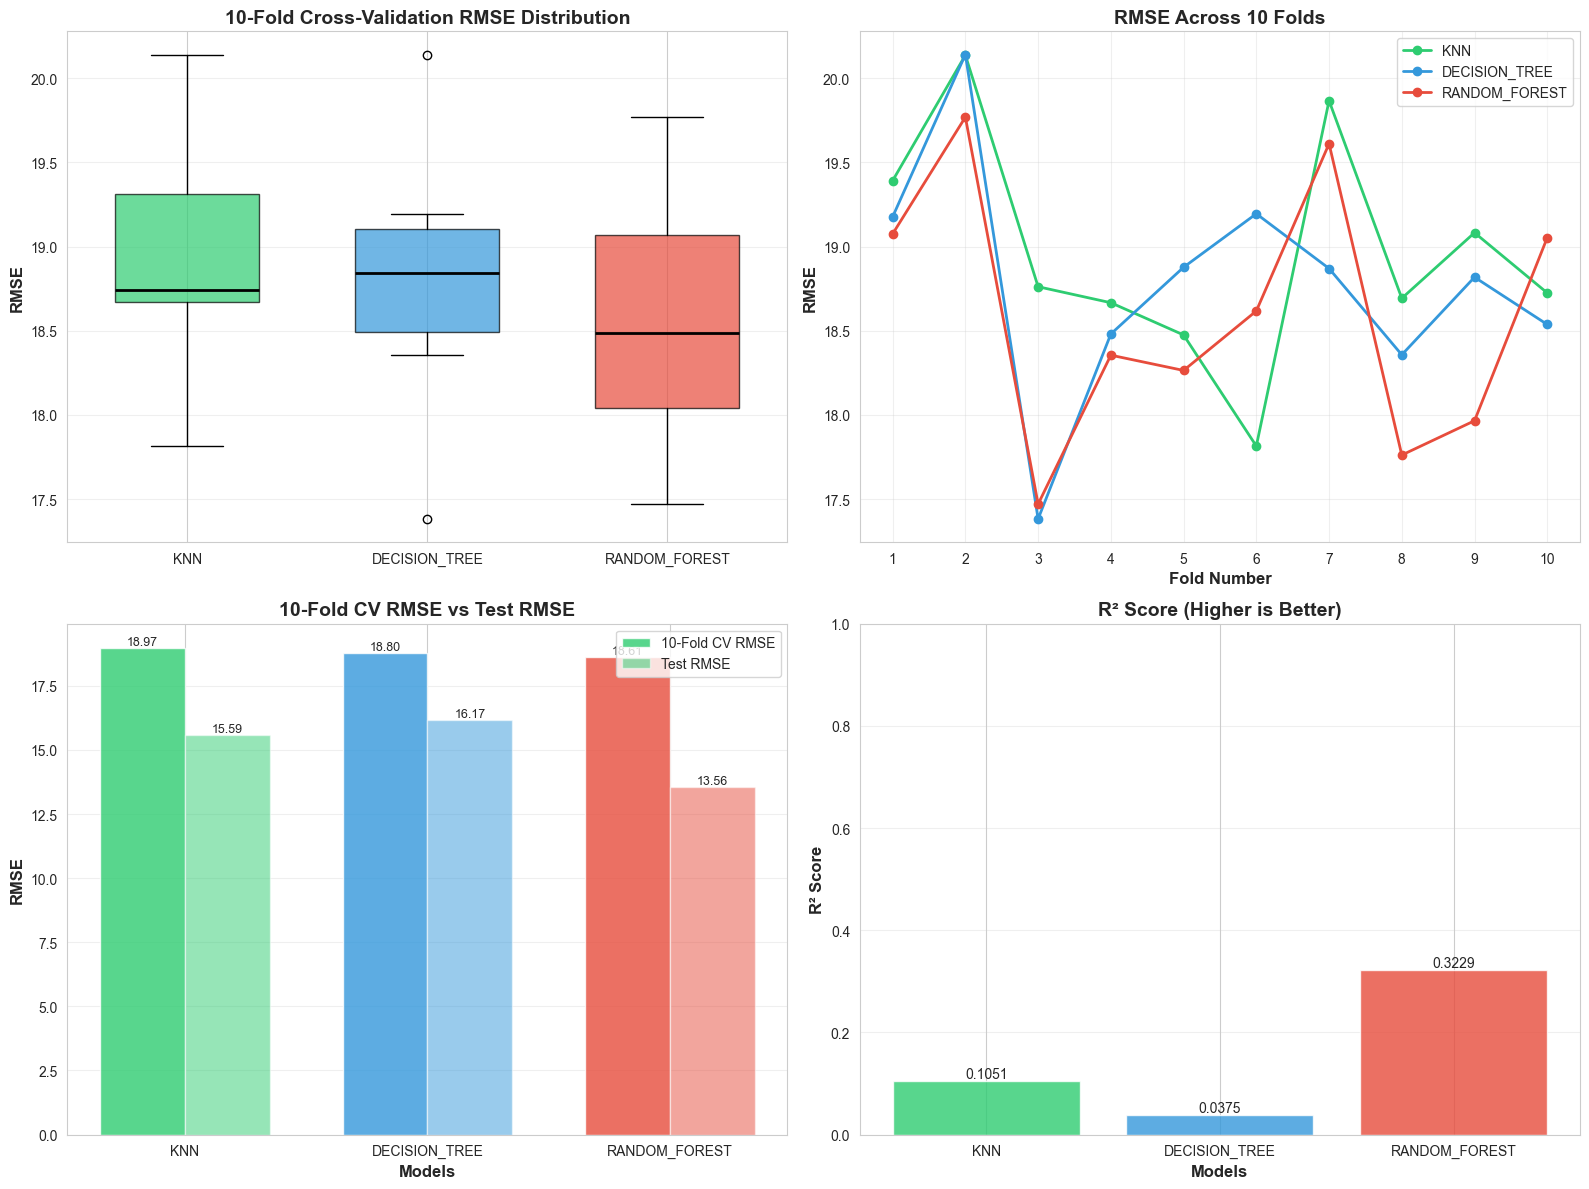


MODEL PERFORMANCE SUMMARY


,Model,CV RMSE,Test RMSE,Test MAE,Test R²
0,KNN,18.9719,15.5873,12.8067,0.1051
1,DECISION_TREE,18.7951,16.1659,13.6919,0.0375
2,RANDOM_FOREST,18.6085,13.5585,11.3906,0.3229



🏆 Best Model: RANDOM_FOREST
   Test RMSE: 13.5585
   Test R²: 0.3229


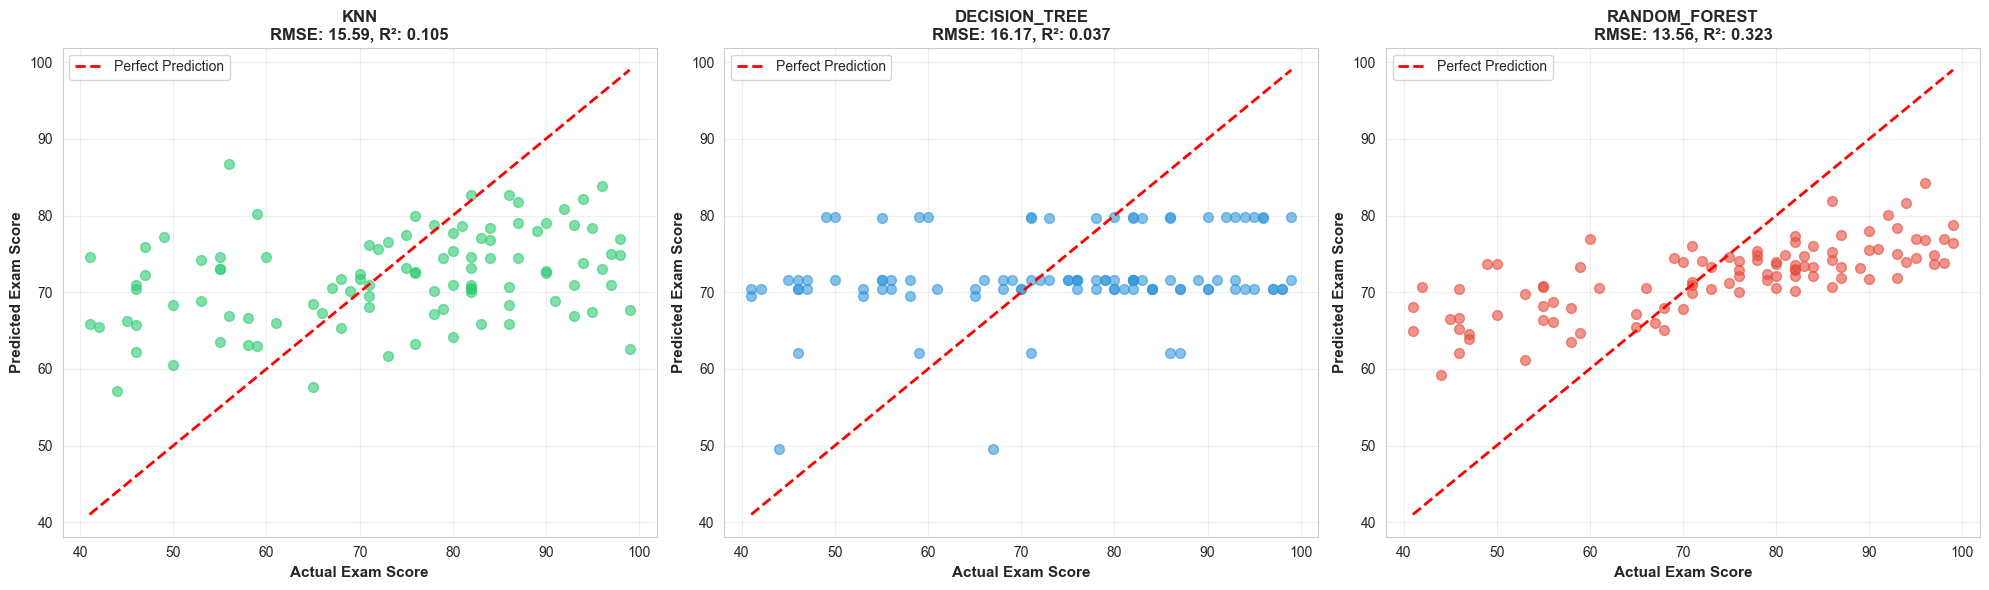

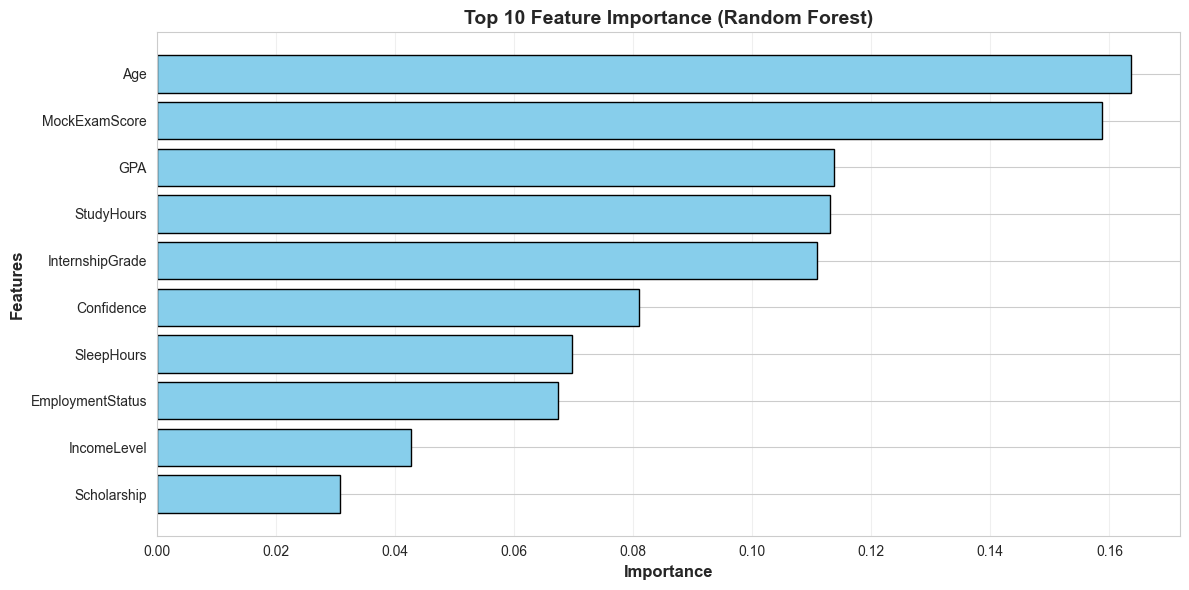


📊 Feature Importance:


,Feature,Importance
3,Age,0.163677
7,MockExamScore,0.158718
8,GPA,0.113766
4,StudyHours,0.113136
10,InternshipGrade,0.110900
6,Confidence,0.081068
5,SleepHours,0.069715
2,EmploymentStatus,0.067366
1,IncomeLevel,0.042627
9,Scholarship,0.030737



💾 Models saved to saved_base_models/
✅ BASE MODELS TRAINING COMPLETE!


ModuleNotFoundError: No module named 'models'

In [ ]:
# Cell 1: Imports
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
import json
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

print("✅ All libraries imported successfully")

# Cell 2: Load Preprocessed Data
X_train = np.load('../processed_data/X_train.npy')
X_test = np.load('../processed_data/X_test.npy')
y_train = np.load('../processed_data/y_train.npy')
y_test = np.load('../processed_data/y_test.npy')

print(f"📊 Data Loaded:")
print(f"   Training samples: {X_train.shape[0]}")
print(f"   Test samples: {X_test.shape[0]}")
print(f"   Features: {X_train.shape[1]}")
print(f"   Target range: [{y_train.min():.2f}, {y_train.max():.2f}]")

# Cell 3: Define Model Configurations
model_configs = {
    'knn': {
        'model': KNeighborsRegressor(),
        'params': {
            'n_neighbors': [3, 5, 7, 9],
            'weights': ['uniform', 'distance']
        }
    },
    'decision_tree': {
        'model': DecisionTreeRegressor(random_state=42),
        'params': {
            'max_depth': [3, 5, 7, 10, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    },
    'random_forest': {
        'model': RandomForestRegressor(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [5, 10, 15, None],
            'min_samples_split': [2, 5, 10]
        }
    }
}

print("🔧 Model Configurations:")
for name in model_configs.keys():
    print(f"   ✓ {name.upper()}")

# Cell 4: Train Models with 10-Fold CV
from sklearn.model_selection import KFold

results = {}
cv = KFold(n_splits=10, shuffle=True, random_state=42)

# Combine train and test for CV
X_full = np.vstack([X_train, X_test])
y_full = np.concatenate([y_train, y_test])

print("=" * 70)
print("TRAINING BASE MODELS WITH 10-FOLD CROSS-VALIDATION")
print("=" * 70)

for name, config in model_configs.items():
    print(f"\n🔄 Training {name.upper()}...")
    
    # Grid search with 10-fold CV
    grid_search = GridSearchCV(
        config['model'],
        config['params'],
        cv=cv,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        return_train_score=True
    )
    
    grid_search.fit(X_full, y_full)
    best_model = grid_search.best_estimator_
    
    # Get CV results
    cv_results = grid_search.cv_results_
    best_index = grid_search.best_index_
    
    # Extract fold scores (convert negative MSE to positive)
    fold_scores = []
    for fold_idx in range(10):
        fold_key = f'split{fold_idx}_test_score'
        fold_scores.append(-cv_results[fold_key][best_index])  # Convert to positive MSE
    
    cv_mean = np.mean(fold_scores)
    cv_std = np.std(fold_scores)
    cv_min = np.min(fold_scores)
    cv_max = np.max(fold_scores)
    
    # Calculate RMSE
    cv_rmse = np.sqrt(cv_mean)
    
    # Test set predictions
    y_pred = best_model.predict(X_test)
    test_mse = mean_squared_error(y_test, y_pred)
    test_rmse = np.sqrt(test_mse)
    test_mae = mean_absolute_error(y_test, y_pred)
    test_r2 = r2_score(y_test, y_pred)
    
    results[name] = {
        'model': best_model,
        'cv_mse_mean': cv_mean,
        'cv_mse_std': cv_std,
        'cv_mse_min': cv_min,
        'cv_mse_max': cv_max,
        'cv_rmse': cv_rmse,
        'cv_10fold_scores': fold_scores,
        'test_mse': test_mse,
        'test_rmse': test_rmse,
        'test_mae': test_mae,
        'test_r2': test_r2,
        'y_pred': y_pred,
        'best_params': grid_search.best_params_
    }
    
    print(f"   ✅ {name.upper()} Trained")
    print(f"      10-Fold CV RMSE: {cv_rmse:.4f} ± {cv_std:.4f}")
    print(f"      Test RMSE: {test_rmse:.4f}")
    print(f"      Test MAE: {test_mae:.4f}")
    print(f"      Test R²: {test_r2:.4f}")
    print(f"      Best Params: {grid_search.best_params_}")

# Cell 5: Visualize 10-Fold CV Results
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

model_names = list(results.keys())
colors = ['#2ecc71', '#3498db', '#e74c3c']

# Plot 1: Box plot of 10-fold scores (RMSE)
fold_data = []
for name in model_names:
    for fold_idx, mse in enumerate(results[name]['cv_10fold_scores'], 1):
        fold_data.append({
            'Model': name.upper(),
            'Fold': fold_idx,
            'RMSE': np.sqrt(mse)
        })

fold_df = pd.DataFrame(fold_data)

box_positions = []
for idx, name in enumerate(model_names):
    model_data = fold_df[fold_df['Model'] == name.upper()]['RMSE']
    bp = axes[0, 0].boxplot([model_data], positions=[idx], widths=0.6,
                            patch_artist=True,
                            boxprops=dict(facecolor=colors[idx], alpha=0.7),
                            medianprops=dict(color='black', linewidth=2))
    box_positions.append(idx)

axes[0, 0].set_xticks(box_positions)
axes[0, 0].set_xticklabels([name.upper() for name in model_names])
axes[0, 0].set_ylabel('RMSE', fontsize=12, fontweight='bold')
axes[0, 0].set_title('10-Fold Cross-Validation RMSE Distribution', fontsize=14, fontweight='bold')
axes[0, 0].grid(axis='y', alpha=0.3)

# Plot 2: Line plot showing each fold's performance
for idx, name in enumerate(model_names):
    fold_rmse = [np.sqrt(mse) for mse in results[name]['cv_10fold_scores']]
    axes[0, 1].plot(range(1, 11), fold_rmse, marker='o', linewidth=2,
                   label=name.upper(), color=colors[idx])

axes[0, 1].set_xlabel('Fold Number', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('RMSE', fontsize=12, fontweight='bold')
axes[0, 1].set_title('RMSE Across 10 Folds', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)
axes[0, 1].set_xticks(range(1, 11))

# Plot 3: CV RMSE vs Test RMSE comparison
x = np.arange(len(model_names))
width = 0.35

cv_rmse_values = [results[name]['cv_rmse'] for name in model_names]
test_rmse_values = [results[name]['test_rmse'] for name in model_names]

bars1 = axes[1, 0].bar(x - width/2, cv_rmse_values, width, label='10-Fold CV RMSE',
                       color=colors, alpha=0.8)
bars2 = axes[1, 0].bar(x + width/2, test_rmse_values, width, label='Test RMSE',
                       color=colors, alpha=0.5)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[1, 0].text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.2f}', ha='center', va='bottom', fontsize=9)

axes[1, 0].set_xlabel('Models', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('RMSE', fontsize=12, fontweight='bold')
axes[1, 0].set_title('10-Fold CV RMSE vs Test RMSE', fontsize=14, fontweight='bold')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels([name.upper() for name in model_names])
axes[1, 0].legend()
axes[1, 0].grid(axis='y', alpha=0.3)

# Plot 4: R² Score comparison
r2_scores = [results[name]['test_r2'] for name in model_names]

bars = axes[1, 1].bar([name.upper() for name in model_names], r2_scores,
                      color=colors, alpha=0.8)

for bar in bars:
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.4f}', ha='center', va='bottom', fontsize=10)

axes[1, 1].set_xlabel('Models', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('R² Score', fontsize=12, fontweight='bold')
axes[1, 1].set_title('R² Score (Higher is Better)', fontsize=14, fontweight='bold')
axes[1, 1].grid(axis='y', alpha=0.3)
axes[1, 1].set_ylim([0, 1])

plt.tight_layout()
plt.show()

# Cell 6: Performance Summary Table
summary_data = []
for name in model_names:
    summary_data.append({
        'Model': name.upper(),
        'CV RMSE': f"{results[name]['cv_rmse']:.4f}",
        'Test RMSE': f"{results[name]['test_rmse']:.4f}",
        'Test MAE': f"{results[name]['test_mae']:.4f}",
        'Test R²': f"{results[name]['test_r2']:.4f}"
    })

summary_df = pd.DataFrame(summary_data)
print("\n" + "=" * 70)
print("MODEL PERFORMANCE SUMMARY")
print("=" * 70)
display(summary_df)

# Find best model
best_model_name = min(results.items(), key=lambda x: x[1]['test_rmse'])[0]
print(f"\n🏆 Best Model: {best_model_name.upper()}")
print(f"   Test RMSE: {results[best_model_name]['test_rmse']:.4f}")
print(f"   Test R²: {results[best_model_name]['test_r2']:.4f}")

# Cell 7: Prediction vs Actual Plots
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for idx, name in enumerate(model_names):
    y_pred = results[name]['y_pred']
    
    # Scatter plot
    axes[idx].scatter(y_test, y_pred, alpha=0.6, s=50, color=colors[idx])
    
    # Perfect prediction line
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    axes[idx].plot([min_val, max_val], [min_val, max_val], 
                   'r--', linewidth=2, label='Perfect Prediction')
    
    # Metrics
    rmse = results[name]['test_rmse']
    r2 = results[name]['test_r2']
    
    axes[idx].set_xlabel('Actual Exam Score', fontsize=11, fontweight='bold')
    axes[idx].set_ylabel('Predicted Exam Score', fontsize=11, fontweight='bold')
    axes[idx].set_title(f'{name.upper()}\nRMSE: {rmse:.2f}, R²: {r2:.3f}',
                       fontsize=12, fontweight='bold')
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Cell 8: Feature Importance (Random Forest)
if 'random_forest' in results:
    feature_names = json.load(open('../processed_data/feature_names.json'))
    
    rf_model = results['random_forest']['model']
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': rf_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(12, 6))
    plt.barh(feature_importance['Feature'][:10], 
             feature_importance['Importance'][:10],
             color='skyblue', edgecolor='black')
    plt.xlabel('Importance', fontsize=12, fontweight='bold')
    plt.ylabel('Features', fontsize=12, fontweight='bold')
    plt.title('Top 10 Feature Importance (Random Forest)', 
              fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print("\n📊 Feature Importance:")
    display(feature_importance)

# Cell 9: Save Models
os.makedirs('../saved_base_models', exist_ok=True)

for name, data in results.items():
    joblib.dump(data['model'], f'../saved_base_models/{name}_model.pkl')

print("\n💾 Models saved to saved_base_models/")
print("✅ BASE MODELS TRAINING COMPLETE!")

# Cell 10: Create and Save Preprocessor for Django
import joblib
import os

models_path = os.path.abspath('..')
if models_path not in sys.path:
    sys.path.insert(0, models_path)

# Import from the correct module path
from regression_preprocessor import RegressionPreprocessor

label_encoders = joblib.load('../processed_data/label_encoders.pkl')
imputer = joblib.load('../processed_data/imputer.pkl')
scaler = joblib.load('../processed_data/scaler.pkl')
feature_names = json.load(open('../processed_data/feature_names.json'))

preprocessor = RegressionPreprocessor(imputer, label_encoders, scaler)

joblib.dump(preprocessor, '../saved_base_models/preprocessor.pkl')
joblib.dump(feature_names, '../saved_base_models/feature_names.pkl')

print("\nPreprocessor saved to ../saved_base_models/")
print("READY FOR DJANGO DEPLOYMENT!")
